In [5]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5889dab5df2a1c2b0ecb1b4ec107a16a54def77639b9e4991ea62aaadaf023d7
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
!pip install yfinance
!pip install pandas
from pyspark.sql import SparkSession
import yfinance as yf
import pandas as pd

# Iniciar uma sessão Spark
spark = SparkSession.builder.appName("StockComparison").getOrCreate()

In [22]:
import yfinance as yf

# Baixar dados para os anos de 2023 e 2024
data_2023 = yf.download("TSLA", start="2023-01-01", end="2023-04-30", interval="1d")
data_2024 = yf.download("TSLA", start="2024-01-01", end="2024-04-30", interval="1d")

# Criar DataFrames do Spark
sdf_2023 = spark.createDataFrame(data_2023.reset_index())
sdf_2024 = spark.createDataFrame(data_2024.reset_index())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [23]:
from pyspark.sql.functions import mean, stddev, col

# Calcular estatísticas para 2023
stats_2023 = sdf_2023.agg(
    mean(col("Close")).alias("mean_close"),
    stddev(col("Close")).alias("stddev_close")
).collect()[0]

# Calcular estatísticas para 2024
stats_2024 = sdf_2024.agg(
    mean(col("Close")).alias("mean_close"),
    stddev(col("Close")).alias("stddev_close")
).collect()[0]

print(f"2023 - Média de Fechamento: {stats_2023['mean_close']}, Desvio Padrão: {stats_2023['stddev_close']}")
print(f"2024 - Média de Fechamento: {stats_2024['mean_close']}, Desvio Padrão: {stats_2024['stddev_close']}")

2023 - Média de Fechamento: 175.03481452847706, Desvio Padrão: 28.211452023690867
2024 - Média de Fechamento: 188.89136396135603, Desvio Padrão: 23.273936360625957


In [24]:
# Exemplo simples: Calcular a média móvel de 7 dias para o preço de fechamento
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, col

windowSpec = Window.orderBy("Date").rowsBetween(-6, 0)
sdf = sdf.withColumn("7_day_avg_close", avg("Close").over(windowSpec))
sdf.select("Date", "Close", "7_day_avg_close").show()

+-------------------+------------------+------------------+
|               Date|             Close|   7_day_avg_close|
+-------------------+------------------+------------------+
|2024-01-02 00:00:00| 248.4199981689453| 248.4199981689453|
|2024-01-03 00:00:00| 238.4499969482422|243.43499755859375|
|2024-01-04 00:00:00|237.92999267578125| 241.5999959309896|
|2024-01-05 00:00:00|237.49000549316406| 240.5724983215332|
|2024-01-08 00:00:00| 240.4499969482422|  240.547998046875|
|2024-01-09 00:00:00| 234.9600067138672|239.61666615804037|
|2024-01-10 00:00:00|233.94000244140625| 238.8057141985212|
|2024-01-11 00:00:00|227.22000122070312|235.77714320591517|
|2024-01-12 00:00:00|218.88999938964844|232.98285784040178|
|2024-01-16 00:00:00|219.91000366210938| 230.4085736955915|
|2024-01-17 00:00:00| 215.5500030517578| 227.2742876325335|
|2024-01-18 00:00:00| 211.8800048828125|223.19286019461495|
|2024-01-19 00:00:00|212.19000244140625|219.94000244140625|
|2024-01-22 00:00:00| 208.8000030517578|

In [26]:
# Convertendo DataFrames do Spark para Pandas
pdf_2023 = sdf_2023.select("Date", "Close").toPandas()
pdf_2024 = sdf_2024.select("Date", "Close").toPandas()

<ipython-input-38-c45397e29487>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # Estilo do gráfico


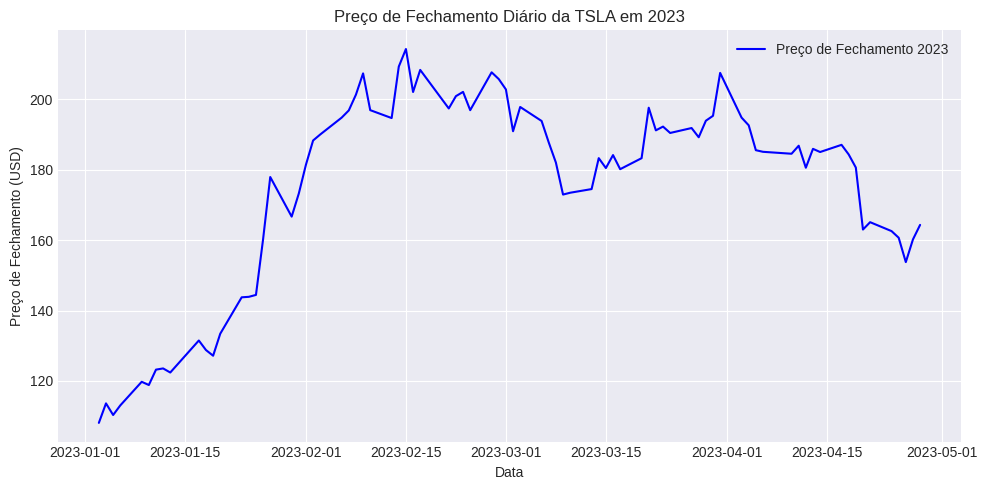

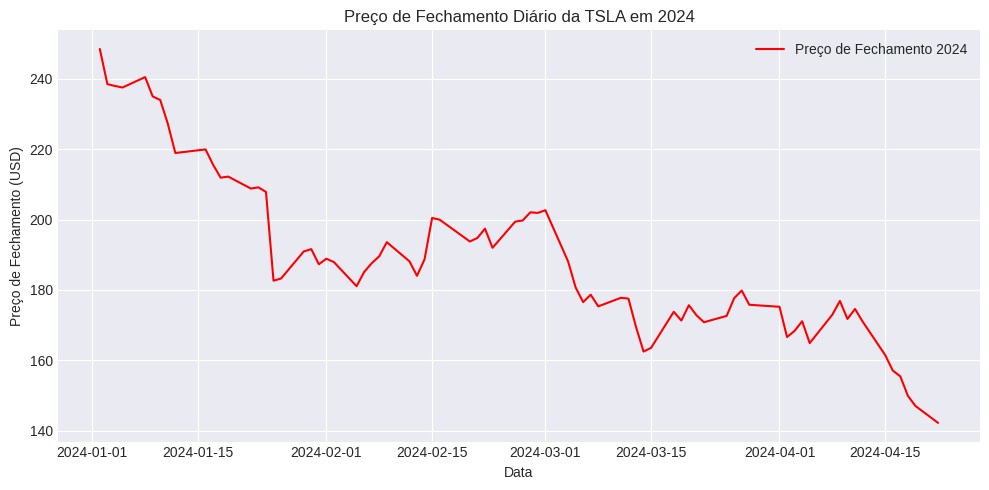

In [38]:
import matplotlib.pyplot as plt

# Configurações para melhorar a estética dos gráficos
plt.style.use('seaborn-darkgrid')  # Estilo do gráfico

# Gráfico para 2023
plt.figure(figsize=(10, 5))  # Define o tamanho da figura
plt.plot(pdf_2023['Date'], pdf_2023['Close'], label='Preço de Fechamento 2023', color='blue')
plt.title('Preço de Fechamento Diário da TSLA em 2023')  # Título do gráfico
plt.xlabel('Data')  # Rótulo do eixo x
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()  # Legenda

plt.tight_layout()
plt.savefig('Comparando as ações da Tesla 2023.png')

plt.show()  # Mostra o gráfico

# Gráfico para 2024
plt.figure(figsize=(10, 5))
plt.plot(pdf_2024['Date'], pdf_2024['Close'], label='Preço de Fechamento 2024', color='red')
plt.title('Preço de Fechamento Diário da TSLA em 2024')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()

plt.tight_layout()
plt.savefig('Comparando as ações da Tesla 2024.png')

plt.show()
